# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [ ]:
pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 134 kB 5.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 43.6 MB/s eta 0:00:01
     |████████████████████████████████| 384 kB 39.5 MB/s eta 0:00:01


In [2]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
                                #transforms.Lambda(lambda x: torch.flatten(x))

# Create training set and define training dataloader
trainval_data = torchvision.datasets.MNIST(root="data", train=True,
                              download=True, transform=transform)
#train_loader = DataLoader(training_data, batch_size=64, shuffle=True)

train_len = int(len(trainval_data) * 0.8)
val_len = len(trainval_data) - train_len
print(f"Using {train_len} examples for training and {val_len} for validation")
train_subset, val_subset = torch.utils.data.random_split(
    trainval_data, [train_len, val_len], generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(dataset=train_subset,shuffle=True,
                                           batch_size=64)
val_loader = torch.utils.data.DataLoader(
    dataset=val_subset, shuffle=False, batch_size=64)



# Create test set and define test dataloader
test_data = torchvision.datasets.MNIST(root="data", train=False,
                             download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=64)

Using 48000 examples for training and 12000 for validation


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

just used toTensor tansformer as images can't be fed the network in raw form

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

3


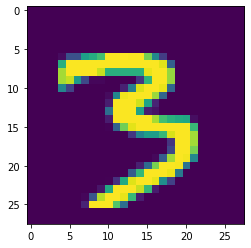

7


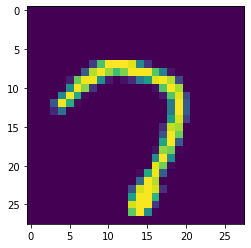

2


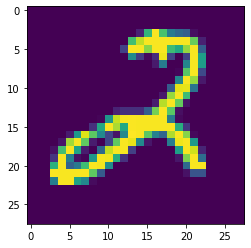

9


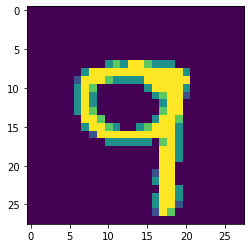

4


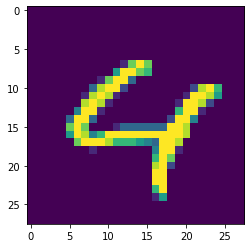

In [4]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(p=0.3)
        self.activation = F.relu
        #self.activation = torch.sigmoid
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 128)
        #self.fc3 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(128, 10)
        self.fc4 = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = torch.flatten(x, 1) 
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.activation(self.fc3(x))
        #x = self.activation(self.fc4(x))
        x = self.fc4(x)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:
net = Net()
if torch.cuda.is_available():
    net= net.to('cuda')
#optimizer = optim.Adam(net.parameters(), lr=0.001)
optimizer = optim.SGD(net.parameters(), lr=0.01,weight_decay= 0.001)#, momentum=0.9
criterion = nn.CrossEntropyLoss()


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [20]:
num_epochs = 50

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()
train_loss = 0.0

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data

        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*inputs.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    
    # Validate
    with torch.no_grad():

        # set the model to evaluation mode
        net.eval()

        valid_loss = 0.0
        
        for i, data in enumerate(val_loader):
            inputs, labels = data

            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            output = net(inputs)
            
            loss_value = criterion(output, labels) 

            
            valid_loss = valid_loss + (
                (1 / (i + 1)) * (loss_value.data.item() - valid_loss)
            )
    
    print(f"Epoch {epoch+1}: training loss {train_loss:.5f}, valid loss {valid_loss:.5f}")
#        _, preds = torch.max(outputs.data, 1)
#        train_correct += (preds == labels).sum().item()
#        train_loss += loss.item()
#    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
#    train_loss_history.append(train_loss/len(train_loader))
#
#
#    val_loss = 0.0
#    val_correct = 0
#    net.eval()
#    for inputs, labels in test_loader:
#       if torch.cuda.is_available():
#           inputs, labels = inputs.cuda(), labels.cuda()
#           net.cuda()
#
#        outputs = net(inputs).cuda()
#        loss = criterion(outputs, labels)
#
#        _, preds = torch.max(outputs.data, 1)
#        val_correct += (preds == labels).sum().item()
#        val_loss += loss.item()
#    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(test_loader):.2f}% validation loss: {val_loss/len(test_loader):.5f}')
#    val_loss_history.append(val_loss/len(test_loader))

Epoch 1: training loss 0.05902, valid loss 0.07681
Epoch 2: training loss 0.05715, valid loss 0.07671
Epoch 3: training loss 0.05769, valid loss 0.07689
Epoch 4: training loss 0.05748, valid loss 0.07570
Epoch 5: training loss 0.05576, valid loss 0.07771
Epoch 6: training loss 0.05686, valid loss 0.07334
Epoch 7: training loss 0.05578, valid loss 0.07351
Epoch 8: training loss 0.05537, valid loss 0.07397
Epoch 9: training loss 0.05370, valid loss 0.07501
Epoch 10: training loss 0.05498, valid loss 0.07252
Epoch 11: training loss 0.05411, valid loss 0.07308
Epoch 12: training loss 0.05305, valid loss 0.07238
Epoch 13: training loss 0.05296, valid loss 0.07248
Epoch 14: training loss 0.05257, valid loss 0.07185
Epoch 15: training loss 0.05098, valid loss 0.07360
Epoch 16: training loss 0.05092, valid loss 0.07633
Epoch 17: training loss 0.05083, valid loss 0.07201
Epoch 18: training loss 0.05147, valid loss 0.07041
Epoch 19: training loss 0.04978, valid loss 0.07285
Epoch 20: training lo

Plot the training loss (and validation loss/accuracy, if recorded).

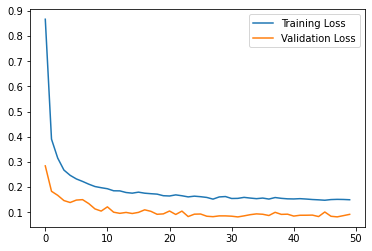

In [11]:
#plt.plot(train_loss_history, label="Training Loss")
#plt.plot(val_loss_history, label="Validation Loss")
#plt.legend()
#plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [24]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0.0 for i in range(10))
class_total = list(0.0 for i in range(10))

net.eval()  # prep model for *evaluation*

for i, data in enumerate (test_loader):
    inputs, labels = data
    
    if torch.cuda.is_available():
        inputs, labels = inputs.cuda(), labels.cuda()
    
    output = net(inputs)
    
    loss = criterion(output, labels)
    # update test loss
    test_loss += loss.item() * inputs.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(inputs.shape[0]):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.6f}\n")

for i in range(10):
    if class_total[i] > 0:
        print(
            f"Test Accuracy of {i}: {100 * class_correct[i] / class_total[i]:.2f}%% "
            f"({int(np.sum(class_correct[i]))}/{int(np.sum(class_total[i]))})"
        )
    else:
        print(f"Test Accuracy of {classes[i]}: N/A (no training examples)")

print(
    f"\nTest Accuracy (Overall): {100.0 * np.sum(class_correct) / np.sum(class_total)}%% "
    f"({int(np.sum(class_correct))}/{int(np.sum(class_total))})"
)

Test Loss: 0.058495

Test Accuracy of 0: 99.08%% (971/980)
Test Accuracy of 1: 99.12%% (1125/1135)
Test Accuracy of 2: 98.26%% (1014/1032)
Test Accuracy of 3: 98.12%% (991/1010)
Test Accuracy of 4: 97.86%% (961/982)
Test Accuracy of 5: 97.87%% (873/892)
Test Accuracy of 6: 98.23%% (941/958)
Test Accuracy of 7: 97.57%% (1003/1028)
Test Accuracy of 8: 98.05%% (955/974)
Test Accuracy of 9: 96.93%% (978/1009)

Test Accuracy (Overall): 98.12%% (9812/10000)


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [ ]:
## YOUR CODE HERE ##

## Saving your model
Using `torch.save`, save your model for future loading.

In [25]:
torch.save(net, './my_mnist_model.pt') 